In [1]:
import re
import os

log_root = "."

# ------------------------------------------------------------
# 正则表达式
# ------------------------------------------------------------

# epoch summary
re_epoch = re.compile(
    r"epoch\s+(\d+)\s+summary:\s*"
    r"dyn_dyn_loss\s*:\s*([\d\.Ee+-]+),\s*"
    r"dyn_sta_loss\s*:\s*([\d\.Ee+-]+),\s*"
    r"dyn_gt_loss\s*:\s*([\d\.Ee+-]+),\s*"
    r"tot_dyn_loss\s*:\s*([\d\.Ee+-]+),\s*"
    r"sta_sta_loss\s*:\s*([\d\.Ee+-]+),"
)

# train loss / train acc
re_train = re.compile(
    r"train loss:\s*([\d\.Ee+-]+),\s*train acc:\s*([\d\.Ee+-]+)"
)

# valid loss / valid acc
re_valid = re.compile(
    r"valid loss:\s*([\d\.Ee+-]+),\s*valid acc:\s*([\d\.Ee+-]+)"
)

# 解析文件名
re_fname = re.compile(
    r"h(\d+)_tp(\d+)_N(\d+)_vocab(\d+)_pos([\d\.]+)_dyn([\d\.]+)_sta([\d\.]+)\.log"
)

# ------------------------------------------------------------
# 解析单个日志文件
# ------------------------------------------------------------
def parse_log(path):

    dyn_dyn = []
    dyn_sta = []
    dyn_gt  = []
    tot_dyn = []
    sta_sta = []

    train_loss = {}
    train_acc = {}

    valid_loss_list = []
    valid_acc_list = []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:

            # epoch summary
            m = re_epoch.search(line)
            if m:
                epoch = int(m.group(1))
                dyn_dyn.append(float(m.group(2)))
                dyn_sta.append(float(m.group(3)))
                dyn_gt.append(float(m.group(4)))
                tot_dyn.append(float(m.group(5)))
                sta_sta.append(float(m.group(6)))
                continue

            # train
            m = re_train.search(line)
            if m:
                epoch = len(train_loss) * 10
                train_loss[epoch] = float(m.group(1))
                train_acc[epoch]  = float(m.group(2))
                continue

            # valid
            m = re_valid.search(line)
            if m:
                valid_loss_list.append(float(m.group(1)))
                valid_acc_list.append(float(m.group(2)))
                continue

    best_vloss = min(valid_loss_list) if valid_loss_list else None
    best_vacc  = max(valid_acc_list) if valid_acc_list else None

    return {
        "dyn_dyn": dyn_dyn,
        "dyn_sta": dyn_sta,
        "dyn_gt":  dyn_gt,
        "tot_dyn": tot_dyn,
        "sta_sta": sta_sta,

        "train_loss": train_loss,
        "train_acc":  train_acc,

        "valid_loss_list": valid_loss_list,
        "valid_acc_list":  valid_acc_list,

        "best_valid_loss": best_vloss,
        "best_valid_acc":  best_vacc,
    }

# ------------------------------------------------------------
# 扫描目录下所有日志文件并解析
# ------------------------------------------------------------
logs = []

for fname in os.listdir(log_root):
    if not fname.endswith(".log"):
        continue

    m = re_fname.match(fname)
    if not m:
        print("[WARN] 跳过未匹配文件名格式:", fname)
        continue

    h = int(m.group(1))
    tp = int(m.group(2))
    N = int(m.group(3))
    N_vocab = int(m.group(4))
    pos_ratio = m.group(5)
    ratio_dyn = m.group(6)
    ratio_sta = m.group(7)

    parsed = parse_log(os.path.join(log_root, fname))

    logs.append({
        "h": h,
        "tp": tp,
        "N": N,
        "N_vocab": N_vocab,
        "pos_ratio": pos_ratio,
        "ratio_dyn": ratio_dyn,
        "ratio_sta": ratio_sta,
        **parsed
    })

print(f"Loaded {len(logs)} logs.")

import json
import os

# 输出目录
save_dir = "."
os.makedirs(save_dir, exist_ok=True)

# 保存文件名
save_path = os.path.join(save_dir, "logs_tradeoff2.json")

# 写入 JSON
with open(save_path, "w", encoding="utf-8") as f:
    json.dump(logs, f, indent=2, ensure_ascii=False)

print(f"[INFO] logs 已成功写入: {save_path}")
print(f"[INFO] 共写入 {len(logs)} 条记录")


Loaded 504 logs.
[INFO] logs 已成功写入: ./logs_tradeoff2.json
[INFO] 共写入 504 条记录


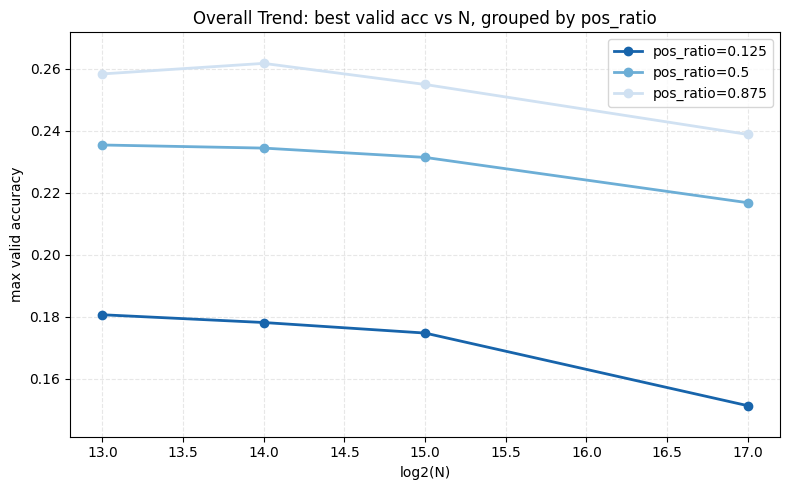

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ------------------------------------------------------------
# 提取所有 N 的列表，并排序
# ------------------------------------------------------------
all_N = sorted({item["N"] for item in logs})
target_pos = ["0.125", "0.5", "0.875"]

# 映射 pos_ratio → color
cmap = plt.get_cmap("Blues_r")
pos_color = {
    "0.125": cmap(0.2),
    "0.5":   cmap(0.5),
    "0.875": cmap(0.8),
}

# ------------------------------------------------------------
# 对每个 (N, pos_ratio) 取所有 ratio_dyn × ratio_sta 中 best_valid_acc 的最大值
# ------------------------------------------------------------
acc_trend = {p: [] for p in target_pos}  # pos_ratio → curve values

for N in all_N:
    for p in target_pos:
        # 找到所有该 N、该 pos_ratio 的日志
        subset = [x for x in logs if x["N"] == N and x["pos_ratio"] == p]

        if not subset:
            acc_trend[p].append(None)
            continue

        # 在所有 dyn×sta 中取最大 best_valid_acc
        vals = [x["best_valid_acc"] for x in subset if x["best_valid_acc"] is not None]
        if len(vals) == 0:
            acc_trend[p].append(None)
        else:
            acc_trend[p].append(max(vals))

# ------------------------------------------------------------
# 开始绘图
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8,5))

# 统一 y 轴范围
all_acc_vals = []
for p in target_pos:
    all_acc_vals += [v for v in acc_trend[p] if v is not None]

if len(all_acc_vals) > 0:
    y_min = min(all_acc_vals)
    y_max = max(all_acc_vals)
else:
    y_min, y_max = 0, 1

# ------------------------------------------------------------
# 绘制三条曲线
# ------------------------------------------------------------
N_log2 = np.log2(all_N)

for p in target_pos:
    ys = acc_trend[p]
    ys_np = np.array([np.nan if v is None else v for v in ys])
    ax.plot(
        N_log2, ys_np, marker="o", linewidth=2,
        color=pos_color[p], label=f"pos_ratio={p}"
    )

# ------------------------------------------------------------
# 图形设置
# ------------------------------------------------------------
ax.set_xlabel("log2(N)")
ax.set_ylabel("max valid accuracy")
ax.set_title("Overall Trend: best valid acc vs N, grouped by pos_ratio")

ax.set_ylim(y_min - 0.01, y_max + 0.01)
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio


# ------------------------------------------------------------
# 指定要分析的 N
# ------------------------------------------------------------
target_N = 8192   # 可修改

# pos_ratio 列表
pos_list = ["0.125", "0.5", "0.875"]

# ------------------------------------------------------------
# 收集该 N 下的所有 dyn、sta 值
# ------------------------------------------------------------
dyn_vals = sorted({float(x["ratio_dyn"]) for x in logs if x["N"] == target_N})
sta_vals = sorted({float(x["ratio_sta"]) for x in logs if x["N"] == target_N})

# ------------------------------------------------------------
# 构建 Z 数据（pos_ratio → (dyn,sta,acc) 点集）
# ------------------------------------------------------------
data_dict = {p: [] for p in pos_list}

for item in logs:
    if item["N"] != target_N:
        continue
    p = item["pos_ratio"]
    if p not in pos_list:
        continue

    dyn = float(item["ratio_dyn"])
    sta = float(item["ratio_sta"])
    acc = item["best_valid_acc"]

    if acc is not None:
        data_dict[p].append((dyn, sta, acc))

# ------------------------------------------------------------
# 统一 z 轴范围
# ------------------------------------------------------------
all_acc = [acc for p in pos_list for (_, _, acc) in data_dict[p]]
z_min = min(all_acc)
z_max = max(all_acc)

# ------------------------------------------------------------
# 创建 1行3列的 subplot
# ------------------------------------------------------------
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}, {"type": "scatter3d"}]],
    subplot_titles=[f"pos_ratio={p}" for p in pos_list]
)

# ------------------------------------------------------------
# 三个 subplot，分别画 scatter3d + line
# ------------------------------------------------------------
for idx, p in enumerate(pos_list):
    pts = sorted(data_dict[p])  # 按 dyn,sta 排序以产生合理连线
    if len(pts) == 0:
        continue

    xs = [x for (x,_,_) in pts]
    ys = [y for (_,y,_) in pts]
    zs = [z for (_,_,z) in pts]

    # scatter3d 点
    fig.add_trace(
        go.Scatter3d(
            x=xs, y=ys, z=zs,
            mode="markers",
            marker=dict(size=4, color=zs, colorscale="Blues", showscale=False),
        ),
        row=1, col=idx+1
    )

    # 设置当前 subplot 的轴标题和范围
    fig.update_scenes(
        dict(
            xaxis_title="ratio_dyn",
            yaxis_title="ratio_sta",
            zaxis_title="best_valid_acc",
            zaxis=dict(range=[z_min, z_max]),
            # xaxis_type="log",
            # yaxis_type="log",
        ),
        row=1, col=idx+1
    )

# ------------------------------------------------------------
# 全局设置
# ------------------------------------------------------------
fig.update_layout(
    height=600,
    width=1600,
    title=f"3D Scatter Performance (N={target_N})",
)

fig.show()


Found 8 curves to plot.


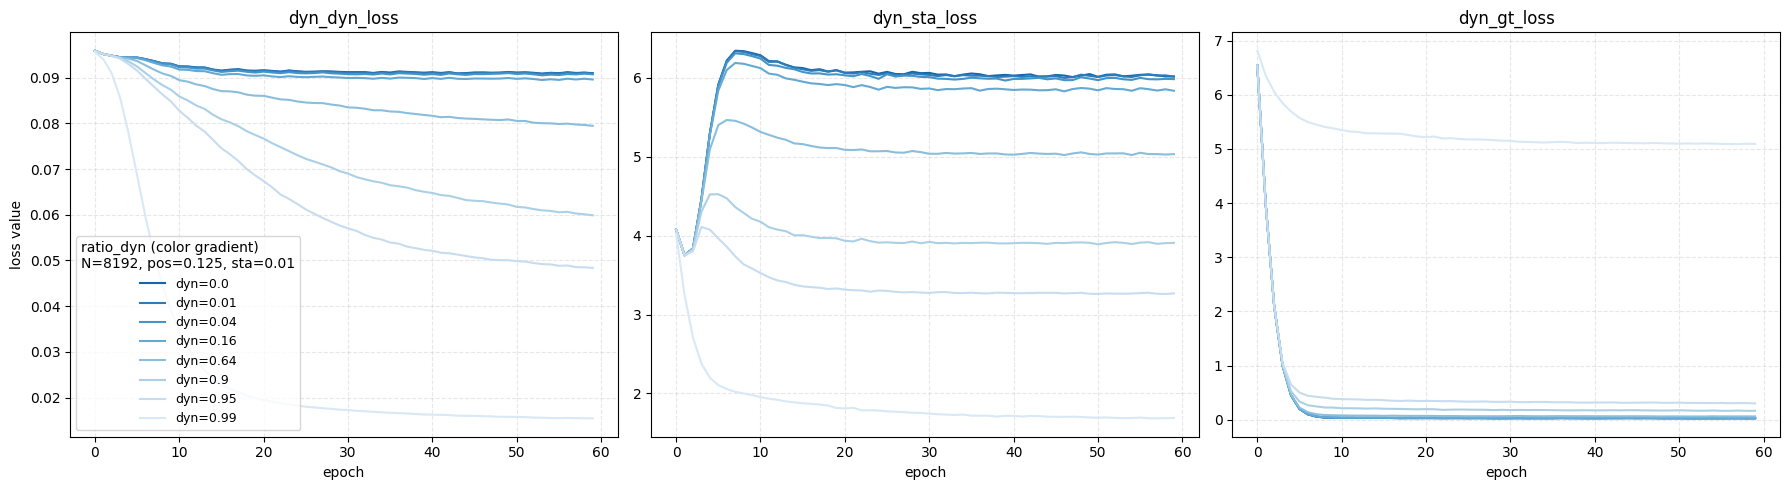

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# 配置：用户可指定
# ------------------------------------------------------------


def _plt(target_N, target_pos, target_ratio_sta):
    # ------------------------------------------------------------
    # 收集满足指定 (N, pos_ratio, ratio_sta) 的所有 ratio_dyn 曲线
    # ------------------------------------------------------------
    curves = []   # list of dict： {ratio_dyn, epoch, dyn_dyn, dyn_sta, dyn_gt}

    for item in logs:
        if item["N"] != target_N:
            continue
        if item["pos_ratio"] != target_pos:
            continue
        if item["ratio_sta"] != target_ratio_sta:
            continue

        r_dyn = float(item["ratio_dyn"])
        curves.append({
            "ratio_dyn": r_dyn,
            "epoch": list(range(len(item["dyn_dyn"]))),
            "dyn_dyn": item["dyn_dyn"],
            "dyn_sta": item["dyn_sta"],
            "dyn_gt":  item["dyn_gt"],
        })

    # 根据 ratio_dyn 从小到大排序，便于颜色渐变
    curves.sort(key=lambda x: x["ratio_dyn"])

    if len(curves) == 0:
        print("No data found for given configuration.")
    else:
        print(f"Found {len(curves)} curves to plot.")


    # ------------------------------------------------------------
    # 颜色设定：从浅到深（Blues_r）
    # ------------------------------------------------------------
    cmap = plt.get_cmap("Blues_r")
    colors = [cmap(v) for v in np.linspace(0.2, 0.85, len(curves))]


    # ------------------------------------------------------------
    # 建立 1×3 figure
    # ------------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    titles = ["dyn_dyn_loss", "dyn_sta_loss", "dyn_gt_loss"]

    for (ax, title) in zip(axes, titles):
        ax.set_xlabel("epoch")
        ax.set_title(title)
        ax.grid(True, linestyle="--", alpha=0.3)

    axes[0].set_ylabel("loss value")

    # ------------------------------------------------------------
    # 绘制每条曲线
    # ------------------------------------------------------------
    for (curve, color) in zip(curves, colors):
        ep = curve["epoch"]

        axes[0].plot(ep, curve["dyn_dyn"], color=color, label=f"dyn={curve['ratio_dyn']}")
        axes[1].plot(ep, curve["dyn_sta"], color=color)
        axes[2].plot(ep, curve["dyn_gt"],  color=color)

    # ------------------------------------------------------------
    # 图例只放在第一张
    # ------------------------------------------------------------
    axes[0].legend(
        title=f"ratio_dyn (color gradient)\nN={target_N}, pos={target_pos}, sta={target_ratio_sta}",
        fontsize=9
    )

    plt.tight_layout()
    plt.show()

target_N = 8192
target_pos = "0.125"        # 可为 "0.125", "0.5", "0.875"
target_ratio_sta = "0.01" # 例如 "0.00", "0.01", "0.04", ...
_plt(target_N, target_pos, target_ratio_sta)

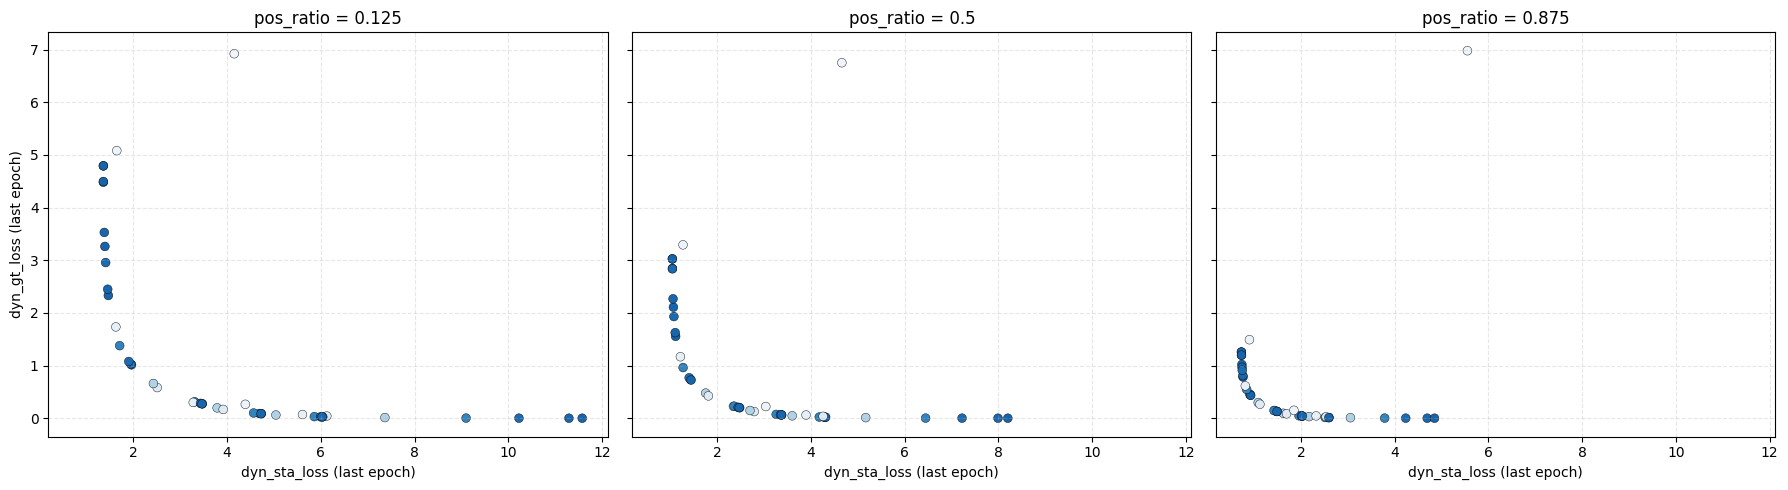

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# 可设定参数
# ------------------------------------------------------------
target_N = 131072
pos_list = ["0.125", "0.5", "0.875"]

# ------------------------------------------------------------
# 收集所有点
# dict: pos_ratio → list of dict{x_last, y_last}
# ------------------------------------------------------------
scatter_data = {p: [] for p in pos_list}

for item in logs:
    if item["N"] != target_N:
        continue
    if item["pos_ratio"] not in pos_list:
        continue

    if len(item["dyn_sta"]) == 0 or len(item["dyn_gt"]) == 0:
        continue

    sta_last = item["dyn_sta"][-1]
    gt_last  = item["dyn_gt"][-1]

    scatter_data[item["pos_ratio"]].append({
        "x": sta_last,
        "y": gt_last,
        "ratio_dyn": float(item["ratio_dyn"]),
        "ratio_sta": float(item["ratio_sta"])
    })

# ------------------------------------------------------------
# 统一 x/y 范围
# ------------------------------------------------------------
all_x = []
all_y = []
for p in pos_list:
    for d in scatter_data[p]:
        all_x.append(d["x"])
        all_y.append(d["y"])

if len(all_x) == 0:
    print("No data found for given configuration.")
    raise SystemExit

x_min, x_max = min(all_x), max(all_x)
y_min, y_max = min(all_y), max(all_y)

# 给一点 padding
pad_x = (x_max - x_min) * 0.05
pad_y = (y_max - y_min) * 0.05
x_min -= pad_x; x_max += pad_x
y_min -= pad_y; y_max += pad_y

# ------------------------------------------------------------
# 颜色：用 ratio_dyn 映射色彩 (Blues_r)
# ------------------------------------------------------------
cmap = plt.get_cmap("Blues_r")

# ------------------------------------------------------------
# 绘制 3 张 subplot
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, pos in zip(axes, pos_list):

    data = scatter_data[pos]
    if len(data) == 0:
        ax.set_title(f"pos_ratio = {pos}\n(no data)")
        continue

    xs = np.array([d["x"] for d in data])
    ys = np.array([d["y"] for d in data])
    cds = np.array([d["ratio_dyn"] for d in data])  # 用 ratio_dyn 作为颜色深浅

    # 映射颜色：ratio_dyn 越大越深
    norm = (cds - cds.min()) / (cds.max() - cds.min() + 1e-9)
    colors = cmap(0.2 + 0.75 * norm)

    ax.scatter(xs, ys, c=colors, s=40, edgecolors="black", linewidths=0.3)

    ax.set_title(f"pos_ratio = {pos}")
    ax.set_xlabel("dyn_sta_loss (last epoch)")
    ax.grid(True, linestyle="--", alpha=0.3)

axes[0].set_ylabel("dyn_gt_loss (last epoch)")

# 统一坐标设置
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()


In [45]:
import plotly.graph_objects as go
import numpy as np

# ------------------------------------------------------------
# 配置：指定 N
# ------------------------------------------------------------
target_N = 8192
pos_list = ["0.125", "0.5", "0.875"]

# ------------------------------------------------------------
# 收集数据：key = pos_ratio → list of points
# 每个点包含：x_last, y_last, z_value
# ------------------------------------------------------------
plot_data = {p: [] for p in pos_list}

for item in logs:
    if item["N"] != target_N:
        continue
    if item["pos_ratio"] not in pos_list:
        continue

    # 需要存在 loss 序列
    if len(item["dyn_sta"]) == 0 or len(item["dyn_gt"]) == 0:
        continue

    sta_last = item["dyn_sta"][-1]
    gt_last  = item["dyn_gt"][-1]
    dyn_last = item["dyn_dyn"][-1]

    r_dyn = float(item["ratio_dyn"])
    r_sta = float(item["ratio_sta"])
    r_gt  = 1.0 - r_dyn - r_sta
    
    # print(r_dyn, r_sta, r_gt)

    # 避免 ratio_gt=0 导致除以 0
    if r_gt <= 1e-2:
        continue
    if r_sta <= 1e-2:
        continue

    z_val = r_sta / r_gt

    plot_data[item["pos_ratio"]].append({
        "x": sta_last,
        "y": gt_last,
        "z": z_val,
        "ratio_dyn": r_dyn,
        "ratio_sta": r_sta,
        "ratio_gt": r_gt
    })

# ------------------------------------------------------------
# 统一 x/y/z 范围
# ------------------------------------------------------------
all_x = []
all_y = []
all_z = []
for p in pos_list:
    for d in plot_data[p]:
        all_x.append(d["x"])
        all_y.append(d["y"])
        all_z.append(d["z"])

x_min, x_max = min(all_x), max(all_x)
y_min, y_max = min(all_y), max(all_y)
z_min, z_max = min(all_z), max(all_z)
print("Z range:", z_min, z_max)

# 给一点 padding
pad_x = (x_max - x_min) * 0.05
pad_y = (y_max - y_min) * 0.05
pad_z = (z_max - z_min) * 0.05

x_min -= pad_x; x_max += pad_x
y_min -= pad_y; y_max += pad_y
z_min -= pad_z; z_max += pad_z

# ------------------------------------------------------------
# 创建 Plotly subplot（3 行 1 列，3D）
# ------------------------------------------------------------
from plotly.subplots import make_subplots
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{"type": "scene"}, {"type": "scene"}, {"type": "scene"}]],
    horizontal_spacing=0.05,
    subplot_titles=[f"pos_ratio={p}" for p in pos_list]
)

# colormap
cmap = plt.get_cmap("Blues_r")

# ------------------------------------------------------------
# 绘制 3D scatter
# ------------------------------------------------------------
for idx, pos in enumerate(pos_list, start=1):
    data = plot_data[pos]
    if len(data) == 0:
        continue

    xs = np.array([d["x"] for d in data])
    ys = np.array([d["y"] for d in data])
    zs = np.array([d["z"] for d in data])
    cds = np.array([d["ratio_dyn"] for d in data])  # 用 ratio_dyn 当颜色源（可换成 ratio_sta 或 ratio_gt）

    # 颜色映射：ratio_dyn 越大越深
    norm = (cds - cds.min()) / (cds.max() - cds.min() + 1e-12)
    colors = [f"rgb({r*255},{g*255},{b*255})" for (r,g,b,_) in cmap(0.2 + 0.75*norm)]

    fig.add_trace(
        go.Scatter3d(
            x=xs, y=ys, z=zs,
            mode="markers",
            marker=dict(
                size=4,
                color=colors,
                opacity=0.85,
                line=dict(width=1, color="black")
            ),
            text=[
                f"dyn={d['ratio_dyn']:.3f}<br>"
                f"sta={d['ratio_sta']:.3f}<br>"
                f"gt={d['ratio_gt']:.3f}<br>"
                f"z=sta/gt={d['z']:.3f}"
                for d in data
            ],
            hovertemplate="dyn_sta_last=%{x:.3f}<br>dyn_gt_last=%{y:.3f}<br>z=%{z:.3f}<extra></extra>"
        ),
        row=1, col=idx
    )

    # 设置坐标范围
    fig.update_scenes(
        xaxis=dict(range=[x_min, x_max], title="dyn_sta_loss(last)"),
        yaxis=dict(range=[y_min, y_max], title="dyn_gt_loss(last)"),
        zaxis=dict(range=[np.log10(z_min), np.log10(z_max)], title="ratio_sta / ratio_gt", type="log"),
        row=1, col=idx
    )

# ------------------------------------------------------------
# Layout
# ------------------------------------------------------------
fig.update_layout(
    height=550,
    width=1600,
    title=f"3D: dyn_sta_loss vs dyn_gt_loss vs ratio_sta/ratio_gt (N={target_N})",
    showlegend=False
)

fig.show()


Z range: 0.04166666666666667 98.99999999999991


/tmp/ipykernel_3415111/2600147763.py:136: RuntimeWarning:

invalid value encountered in log10

